In [1]:
# Za slucaj da neko koristi Python 2
from __future__ import print_function, division

# Keras
from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from PIL import Image
from keras.optimizers import Adam

import matplotlib.pyplot as plt

from tqdm import tqdm
import sys
import os
import numpy as np

# Clear previous reuslts
! rm -rf images

# Create directory
! mkdir images

Using TensorFlow backend.


In [2]:
! wget https://drive.google.com/file/d/1jdJXkQIWVGOeb0XJIXE3YuZQeiEPd8rM/view

--2019-05-20 08:30:32--  https://drive.google.com/file/d/1jdJXkQIWVGOeb0XJIXE3YuZQeiEPd8rM/view
Resolving drive.google.com (drive.google.com)... 74.125.141.139, 74.125.141.100, 74.125.141.138, ...
Connecting to drive.google.com (drive.google.com)|74.125.141.139|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘view’

view                    [ <=>                ] 119.66K  --.-KB/s    in 0.01s   

2019-05-20 08:30:33 (11.2 MB/s) - ‘view’ saved [122531]



In [3]:
# Mali paket koji omogucava da se pruezmu podaci sa Google Drive-a
! pip install gdown

In [4]:
# Podaci preuzeti sa repozitorijuma: https://github.com/Mckinsey666/Anime-Face-Dataset
! gdown 'https://drive.google.com/uc?id=1jdJXkQIWVGOeb0XJIXE3YuZQeiEPd8rM&export=download'

Downloading...
From: https://drive.google.com/uc?id=1jdJXkQIWVGOeb0XJIXE3YuZQeiEPd8rM&export=download
To: /content/data.zip
231MB [00:03, 65.8MB/s]


In [0]:
# Vrsimo otpakivanje podataka (> /dev/null sluzi da se ne zagusi konzola)
! unzip data.zip > /dev/null

Pokazujemo nekoliko instanci. Možemo zaključiti da smo slike dobili u direktorijumu `data` u kojem se nalazi veliki broj slika u formatu `png`.

In [6]:
# Pokazujemo nekoliko instanci
! ls data | head

10000.png
10001.png
10002.png
10003.png
10004.png
10005.png
10006.png
10007.png
10008.png
10009.png


Sample image: data/12777.png


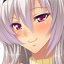

In [7]:
base_dir = 'data'
imgs = os.listdir(base_dir)
n_instances = len(imgs)

k = np.random.randint(low=0, high=n_instances)

# Prikazujemo jednu sliku
sample = os.path.join(base_dir, imgs[k])
print('Sample image: {}'.format(sample))
img = Image.open(sample)

img_rows, img_cols = img.size

img

In [0]:
X_train = np.zeros((n_instances, img_rows, img_cols, 3))

In [9]:
print('Zauzece memorije: {} MB'.format(X_train.nbytes / 1024 / 1024))

Zauzece memorije: 2020.40625 MB


In [10]:
for i, img_name in tqdm(enumerate(imgs), total=n_instances):
    img_path = os.path.join(base_dir, img_name)
    pil_img = Image.open(img_path)
    X_train[i] = np.array(pil_img)

100%|██████████| 21551/21551 [00:08<00:00, 2421.20it/s]


In [11]:
print(f'X_train.shape {X_train.shape}')
print('Zauzece memorije: {} MB'.format(X_train.nbytes / 1024 / 1024))

X_train.shape (21551, 64, 64, 3)
Zauzece memorije: 2020.40625 MB


# Klasa `DCGAN`
DCGAN (eng. Deep Convolutional Generative adversarial network) predstavlja jednu od jednostavnijih varijanti generativnih suprotstavljenih mreža. Sistem se sastoji iz dve mreže:

- Generatora - ključna stvar je operacija transponovane konvolucije,
- Diskriminatora - regularna konvolutivna mreža za binarnu klasifikaciju.

U primeru koji sledi, biće ilustrovana implementacija DCGAN-a pomoću biblioteke KERAS.

In [0]:
class DCGAN():
    def __init__(self, img_rows, img_cols, channels, latent_dim):
        # Postavljaju se parametri mreze.
        # U nasem slucaju, kako radimo nad podacima iz skupa MNIST,
        # postavljam velicinu slike na 28x28 i
        # broj kanala na 1 (crno bele slike).
        self.img_rows = img_rows
        self.img_cols = img_cols
        self.channels = channels
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        
        # Ovaj parametar predstavlja dimenzionalnost latentnog prostora
        # iz kojeg ce generator da generise slike.
        self.latent_dim = latent_dim

        # Optimizator koji ce biti koriscen.
        optimizer = Adam(0.0002, 0.5)

        # Konstruisemo diskriminator.
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy'])

        # Konstruisemo generator.
        self.generator = self.build_generator()

        # The generator takes noise as input and generates imgs
        # Postavljamo da generator kao ulaz uzima vektor z.
        z = Input(shape=(self.latent_dim,))
        img = self.generator(z)

        # U kombinovanom modelu jedino se trenira generator.
        self.discriminator.trainable = False

        # The discriminator takes generated images as input and determines validity
        # Diskriminator uzima generisane slike kao ulaz i pokusava
        # da utvrdi da li su generisane ili ne.
        valid = self.discriminator(img)

        # Kombinovani model -> Obucavamo generator da prevari diskriminator.
        self.combined = Model(z, valid)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)

    def build_generator(self):

        model = Sequential()

        # Generator je mreza koja od vektora dimenzije `latent_dim`
        # konstruise sliku dimenzija 28x28x1
        model.add(Dense(128 * 16 * 16, activation="relu", input_dim=self.latent_dim))
        model.add(Reshape((16, 16, 128)))
        model.add(UpSampling2D())
        model.add(Conv2D(128, kernel_size=3, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))
        model.add(UpSampling2D())
        model.add(Conv2D(64, kernel_size=3, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))
        model.add(Conv2D(self.channels, kernel_size=3, padding="same"))
        model.add(Activation("tanh"))

        model.summary()

        noise = Input(shape=(self.latent_dim,))
        img = model(noise)

        return Model(noise, img)

    def build_discriminator(self):

        model = Sequential()

        model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=self.img_shape, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
        model.add(ZeroPadding2D(padding=((0,1),(0,1))))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(256, kernel_size=3, strides=1, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Flatten())
        model.add(Dense(1, activation='sigmoid'))

        model.summary()

        img = Input(shape=self.img_shape)
        validity = model(img)

        return Model(img, validity)

    def train(self, X_train, epochs, batch_size=128, save_interval=50):

        # Load the dataset
#         (X_train, _), (_, _) = mnist.load_data()

        # Rescale -1 to 1
        X_train = X_train / 127.5 - 1
#         X_train = np.expand_dims(X_train, axis=3)

        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))
        
        # Vektori za gresku i preciznost po epohi koje cemo
        # zeleti da vizualizujemo kada prodje proces obucavanja.
        g_losses = np.ones((epochs))
        d_losses = np.ones((epochs))
        d_acc = np.ones((epochs))

        for epoch in tqdm(range(epochs)):

            # ---------------------
            #  Treniramo diskriminator
            # ---------------------

            # Biramo nasumicno polovinu slika
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[idx]

            # Generisemo batch laznih slika
            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
            gen_imgs = self.generator.predict(noise)

            # Treniramo diskriminator
            # - Za prave slike koristimo vektor 'valid' koji sadrzi jedinice
            # - Za lazne slike koristimo vektor 'fake' koji sadrzi nule
            d_loss_real = self.discriminator.train_on_batch(imgs, valid)
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)
            
            # Izracunavamo gresku kao aritmeticku sredinu greske na
            # pravim i laznim slikama.
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
            
            # Belezimo dobijene vrednosti i nase vektore vrednosti
            d_losses[epoch] = d_loss[0]
            d_acc[epoch] = d_loss[1]
            
            # ---------------------
            #  Train Generator
            # ---------------------

            # Treniramo generator (koji zeli da prevari diskriminator)
            # Uocite argumente u pozivu funkcije:
            # arg1: Sum
            # arg2: Zapisujemo kao da su pravi podaci
            g_loss = self.combined.train_on_batch(noise, valid)
            
            # Belezimo gresku generatora
            g_losses[epoch] = g_loss
            
            # Prikazujemo korisniku statistike obucavanja
            # Nije lose staviti ovo pod komentar i koristiti tqdm
            # kako se ne bi prepunula konzola za slucaj da se koristi 
            # veliki broj epoha.
            # print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

            # If at save interval => save generated image samples
            # Cuvamo sliku u zavisnosti od prosledjenog parametra
            # za cuvanje fotografija.
            if epoch % save_interval == 0:
                self.save_imgs(epoch)
                
        return d_losses, g_losses, d_acc

    def save_imgs(self, epoch):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        gen_imgs = self.generator.predict(noise)

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c, figsize=(20,10))
        plt.tight_layout()
        cnt = 0
        for i in range(r):
            for j in range(c):
#                 axs[i,j].imshow(gen_imgs[cnt, :,:,0])
                axs[i,j].imshow(gen_imgs[cnt, :, :])
                axs[i,j].axis('off')
                cnt += 1
        fig.savefig("images/manga_%d.png" % epoch)
        plt.close()

    def generate_img(self, z):
        gen_imgs = self.generator.predict(z)
        
        # Rescale to 0-1
        gen_imgs = 0.5 * gen_imgs + 0.5
        
        return gen_imgs


In [13]:
channels = 3
latent_dim = 100

dcgan = DCGAN(img_rows, img_cols, channels, latent_dim)

epochs = 6000
batch_size = 32
save_interval = 50

d_losses, g_losses, d_acc = dcgan.train(X_train, epochs=epochs, batch_size=batch_size, save_interval=save_interval)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 32, 32, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 17, 17, 64)        0         
_________________________________________________________________
batch_normalization_1

  0%|          | 0/6000 [00:00<?, ?it/s]

Instructions for updating:
Use tf.cast instead.


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
100%|██████████| 6000/6000 [15:54<00:00,  7.94it/s]


In [14]:
! nvidia-smi

Mon May 20 08:47:03 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 410.79       CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P0    79W / 149W |   3603MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
import os
imgs = os.listdir('images')
imgs.sort(key=lambda x: int(x.split('_')[1].split('.')[0]))

In [0]:
from google.colab import files
files.download(os.path.join('images', imgs[-10])) 

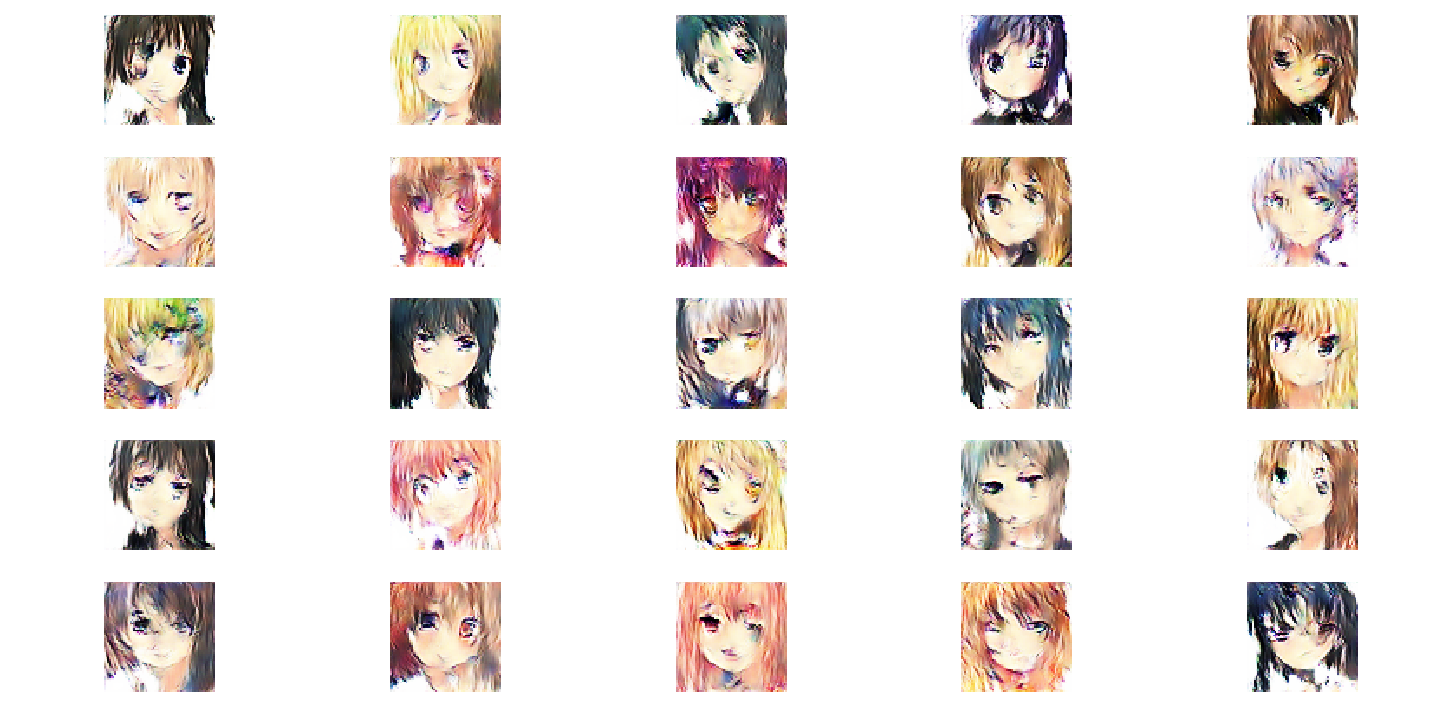

In [17]:
the_img = Image.open(os.path.join('images', imgs[-10]))
the_img

In [0]:
def show_loss(d_losses, g_losses):
    plt.figure(figsize=(20,10))
    plt.plot(range(epochs), d_losses)
    plt.plot(range(epochs), g_losses)
    plt.xlabel('Epoha')
    plt.ylabel('Loss')
    plt.legend(['Discriminator loss', 'Generator loss'])

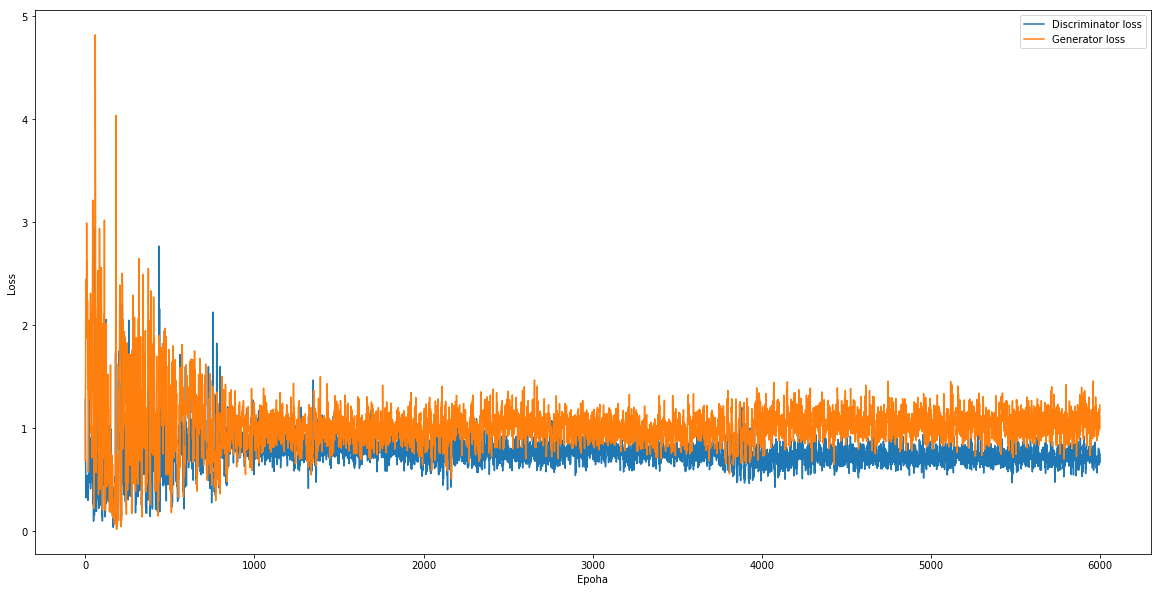

In [19]:
show_loss(d_losses, g_losses)

In [0]:
def show_acc(d_acc):
    plt.figure(figsize=(20,10))
    plt.plot(range(epochs), d_acc)
    plt.xlabel('Epoha')
    plt.ylabel('Preciznost diskriminatora')    

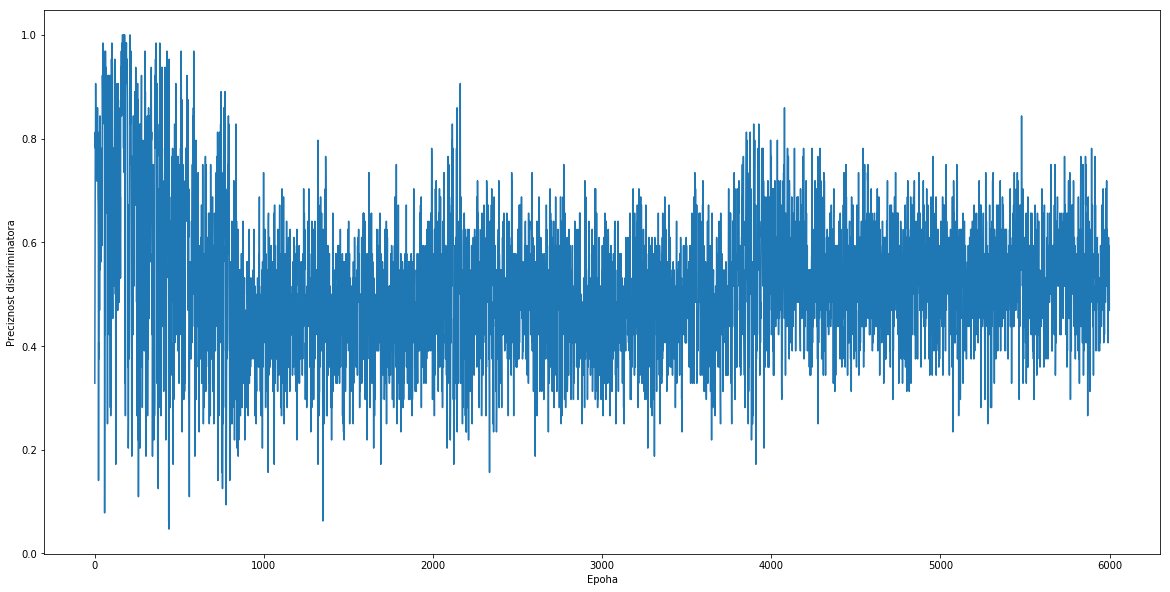

In [21]:
show_acc(d_acc)

In [24]:
z = np.random.normal(0, 1, (1, dcgan.latent_dim))
img = dcgan.generate_img(z)
img = np.squeeze(img)
print(img.shape)

(64, 64, 3)


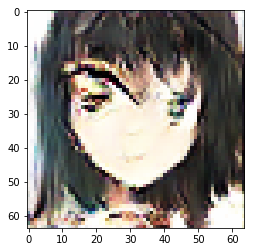

In [25]:
plt.imshow(img, cmap='Greys')

DOMAĆI:

- Šta se desi ukoliko dimenzionalnost latentnog prostora spustimo na vrlo nizak, broj, na primer 2? 
- Da li može da obučite GAN tako da radi iole dobro za tako mali latentni prostor?
- Ako uspete, da li primećujete neko pravilo kada vektoru latentnog prostora varirate samo jednu koordinatu?